### **SOW-MKI49-2019-SEM1-V: NeurIPS**
#### Project: Neurosmash

This is the info document on the (updated*) Neurosmash environment that you will be using for your project. It contains background info and skeleton code to get you started.

### Project

In the next 4 + 1 weeks, you will be working exclusively on your project in the practicals. The goal is to take what has been discussed in class and what you have already worked on in the earlier practicals, and apply them on a RL problem in a novel environment. Note that while the earlier practicals were intended to give you the opportunity to gain experience with various RL topics and were not graded, your project will constitute 50% of your final grade.

Your project grade will be based on the following components:
- Online demonstration
- Source code
- Written report

These components will be evaluated based on performance, creativity, elegance, rigor and plausibility.

While you can use the material from earlier practicals (e.g., REINFORCE, DQN, etc.) as a boilerplate, you are also free to take any other approach be it imitation learning or world models for your project.

In addition to the practical sessions, we will provide additional support in the coming four weeks. You can email any of us to set up an appointment for discussing your project.

### Environment

Briefly, there are two agents: Red and Blue. Red is controlled by you. Blue is controlled by the environment "AI".* Both agents always run forward with a speed of 3.5 m/s*. If one of them gets within the reach of the other (a frontal sphere with 0.5 m radius), it gets pushed away automatically with a speed of 3.5 m/s. The only thing that the agents can do is to turn left or right with an angular speed of 180 degrees/s. This means that there are three possible discrete actions that your agent can take every step: Turn nowhere, turn left and turn right. For convenience, there is also a fourth built-in action which turns left or right with uniform probability. An episode begins when you reset the environment and ends when one of the agents fall off the platform. At the end of the episode, the winning agent gets a reward of 10 while the other gets nothing. Therefore, your goal is to train an agent who can maximize its reward by pushing the other agent off the platform or making it fall off the platform by itself.

* None that all times are simulation time. That is, 0.02 s per step when timescale is set to one.

* Basically, Blue is artificial but not really intelligent. What it does is that every 0.5 s, it updates its destination to the current position of Red plus some random variation (a surrounding circle with a radius of 1.75 m) and smoothly turns to that position.

### *Updates

* There has been several small changes made to the lite version based on your feedback. Most notable ones are:
- Bugs have (hopefully) been completely eliminated. Any remaining bug/glitch that your agent "learns" exploit will be considered fair game.

- TCP/IP interface has been made more robust (you can now stop and start the simulation with the gui. no need to quit and rerun the environment anymore to reset it if something goes wrong.)
- Animations/graphics have been updated (you can now tell what is going on more easily. agents actually fall down, etc.)
- Last but not least, size and timescale settings have been added (you can now change the resolution and the speed of the environment to make the simulation run faster). In other words:

Size => This is the size of the texture that the environment is rendered. This is set to 784 by default, which will result in a crisp image but slow speed. You can change the size to a value that works well for your environment should not go too low.

Timescale => This is the simulation speed of the environment. This is set to 1 by default. Setting it to n will make the simulation n times faster. In other words, less (if n < 1) or more (if n > 1) simulation time will pass per step. You might want to increase this value to around 10 if you cannot train your models fast enough so that they can sample more states in a shorter number of steps at the expense of precision.

### Misc. FAQs

Q: Can we get HCP access?  
A: I will try provide access to the AI HPC cluster if you require additional resources. If this is something that you would like, please contact me. Note however that you should use the cluster for training your final model and not development.

Q: Will the environment code be shared?  
A: Yes. I will share the entire unityproject at the end of the course (but without the 3D agent models).

Q: Is there a environment version that can be played with a mouse/keyboard?  
A: No but I will make one and update Brightspace when I have some free time.

Q: I found a bug/glitch. What should I do?  
A: Please let me know and I will fix it. Do note however that any updates from this point on will be optional to adopt. That is, you can keep working on the current environment if you so wish or think that updating will disadvantage you in any way.

### Skeleton code

- You should first add the Neurosmash file to your working directory or Python path.

In [1]:
import numpy as np
import socket
from PIL import Image, ImageChops
import struct
import math
import time
import random
import matplotlib.pyplot as plt
import matplotlib
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Neurosmash_Agent:
    def __init__(self):
        pass

    def step(self, end, reward, state):
        # return 0 # nothing
        # return 1 # left
        # return 2 # right
        return   2 # random

class Neurosmash_Environment:
    def __init__(self, ip = "127.0.0.1", port = 13000, size = 768, timescale = 1):
        self.client     = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.ip         = ip
        self.port       = port
        self.size       = size
        self.timescale  = timescale

        self.client.connect((ip, port))

    def reset(self):
        self._send(1, 0)
        return self._receive()

    def step(self, action):
        self._send(2, action)
        return self._receive()

    def state2image(self, state):
        return Image.fromarray(np.array(state, "uint8").reshape(self.size, self.size, 3))

    def _receive(self):
        # Kudos to Jan for the socket.MSG_WAITALL fix!
        data   = self.client.recv(2 + 3 * self.size ** 2, socket.MSG_WAITALL)
        end    = data[0]
        reward = data[1]
        state  = [data[i] for i in range(2, len(data))]

        return end, reward, state

    def _send(self, action, command):
        self.client.send(bytes([action, command]))

In [2]:
# These are the default environment arguments. They must be the same as the values that are set in the environment GUI.
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to
port       = 13000       # Port number that the TCP/IP interface listens to
size       = 50         # Please check the Updates section above for more details
timescale  = 10           # Please check the Updates section above for more details

agent = Neurosmash_Agent() # This is an example agent.
                           # It has a step function, which gets reward/state as arguments and returns an action.
                           # Right now, it always outputs a random action (3) regardless of reward/state.
                           # The real agent should output one of the following three actions:
                           # none (0), left (1) and right (2)

environment = Neurosmash_Environment(ip=ip, port=port, size=size, timescale=timescale) # This is the main environment.
                                       # It has a reset function, which is used to reset the environment before episodes.
                                       # It also has a step function, which is used to which steps one time point
                                       # It gets an action (as defined above) as input and outputs the following:
                                       # end (true if the episode has ended, false otherwise)
                                       # reward (10 if won, 0 otherwise)
                                       # state (flattened size x size x 3 vector of pixel values)
                                       # The state can be converted into an image as follows:
                                       # image = np.array(state, "uint8").reshape(size, size, 3)
                                       # You can also use to Neurosmash.Environment.state2image(state) function which returns
                                       # the state as a PIL image

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
    

In [4]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


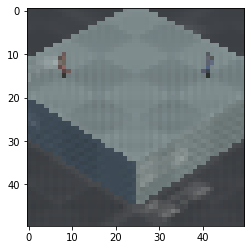

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Initialize environment, gather initial state
end, reward, state = environment.reset()

screen = environment.state2image(state)
plt.imshow(screen)
screen_shape = np.shape(screen)
n_actions = 3

#TODO: make a direct state2input function
def image2input(screen):
    """ Converts an image gained from the environment (through environment.state2image) to ready-to-use input"""
    # Transpose to pytorch order of dimensions (cwh)
    screen = np.transpose(screen, axes=(2,0,1))
    # Translate to rgb float values
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Convert to tensor
    screen = torch.from_numpy(screen)
    # Add batch dimension, yeet to device
    screen = screen.unsqueeze(0).to(device)
    return screen
    

# Initialize DQN network
policy_net = DQN(screen_shape[0], screen_shape[1], n_actions).to(device)
target_net = DQN(screen_shape[0], screen_shape[1], n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)
episode_durations = []


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #return target_net(state).max(1)[1].view(1, 1)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [21]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    #print('VALUE ', target_net(non_final_next_states).max(1)[0].detach().numpy())
    #print('ACTION ', target_net(non_final_next_states).max(1)[1].detach().numpy())
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    #next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    next_state_values[non_final_mask] = target_net(non_final_next_states).argmax()[1].detach()
    #print('Optimize: ', target_net(non_final_next_states).max(1)[0])
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [22]:
num_episodes = 1000
steps_done = 0

for i_episode in range(num_episodes):
    timer = time.time()
    
    # Initialize the environment and state
    end, reward, state = environment.reset()
    state = image2input(environment.state2image(state))
    last_state = state
    current_state = state
    state = current_state - last_state
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        end, reward, state = environment.step(action.item())
        if reward == 10:
            print("Victory!!!!")
        #reward += 20
        state = image2input(environment.state2image(state))
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_state = current_state
        current_state = state
        if not end:
            next_state = current_state - last_state
        else:
            next_state = None


        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if end:
            episode_durations.append(t + 1)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    print("episode", i_episode, "completed in", time.time() - timer)
    
    if (i_episode+1)%500 == 0:
        torch.save(policy_net.state_dict(), "dict_e" + str(i_episode+1) +".kek")
        

print('Complete')
# env.render()
# env.close()
plt.ioff()
plt.show()

VALUE  [24.10326  24.269516 24.334242 24.231173 24.302174 24.17516  24.377739
 24.406607 24.277107 24.123074 24.389202 24.307959 24.15195  23.930634
 24.392162 24.277138 24.55449  24.170319 24.163061 23.952114 24.4642
 24.18232  24.341003 24.421566 24.254269 24.017115 24.314186 24.356882
 23.570148 25.1016   24.235365 24.02776  24.155521 24.398022 24.189661
 24.048306 24.258045 23.939537 24.118725 23.948664 24.586922 24.225298
 24.321783 24.115154 24.18068  24.008541 23.82719  23.929434 24.284544
 24.265453 24.399532 24.30355  24.112026 23.704243 24.215513 24.317394
 24.276577 24.187126 24.832623 24.607777 24.184797 24.451302 24.323788
 24.073967 23.906097 24.234728 24.313824 23.318344 24.34348  24.278297
 24.197926 23.911888 24.191866 24.209633 24.202953 24.238667 24.478354
 24.17802  24.455742 24.264797 24.62564  24.288595 24.320915 24.197758
 24.010084 24.284481 24.645985 24.379238 24.179688 23.842815 23.987549
 24.194836 24.36697  24.258831 24.201826 23.994274 24.048868 24.174946
 

VALUE  [23.930634 24.217794 24.224133 24.323788 24.3182   24.399532 24.198706
 23.990177 24.547737 24.338337 24.258045 24.379238 24.13719  24.31291
 24.278166 24.227417 24.31329  24.377739 24.4642   24.222775 24.362917
 24.74407  24.298409 24.017115 24.284481 24.478354 24.361423 24.160067
 23.842815 23.950455 24.265453 24.41753  24.155521 24.232632 24.25248
 24.113531 24.284544 24.235365 24.119122 24.31771  24.118725 24.112026
 24.202953 23.911888 24.157372 24.264797 24.277107 24.817139 23.907902
 24.41975  24.351982 24.313824 24.048868 24.183842 24.521925 24.242191
 24.197926 23.952114 24.170319 24.398022 24.104502 23.906097 24.496412
 24.314186 24.55449  24.194836 24.62952  23.948664 24.36697  24.17516
 24.334242 24.33826  23.981617 24.301128 24.451302 24.189661 24.246084
 24.62564  24.163061 24.82753  24.303127 24.389202 24.254269 24.285759
 24.320915 24.127022 24.182182 24.10326  24.18068  23.987549 24.276577
 24.572807 24.224499 24.108425 24.269516 24.322216 24.179688 25.1185
 24.

VALUE  [24.62952  24.128044 24.406607 23.570148 24.305855 24.05904  24.187126
 24.127514 23.930634 24.365528 24.205284 24.10326  24.211714 24.403534
 24.268063 24.34348  24.298409 24.115704 24.298985 24.394047 24.364754
 24.33826  23.318344 24.163483 24.117481 24.258675 24.29506  24.645985
 24.179688 24.18232  24.101082 24.076532 24.442217 23.97202  24.332632
 24.265453 23.717014 23.948664 24.275507 24.284481 24.108425 24.341496
 24.314186 24.607777 24.28286  24.281498 24.389202 24.362917 24.219437
 24.157372 24.3182   24.277107 24.875134 24.191866 25.1185   24.073967
 24.017115 24.372879 24.182182 23.93978  24.254438 24.451302 23.82061
 24.278166 24.42252  24.509483 24.127022 24.224499 24.22946  24.619354
 24.184797 24.4642   24.048214 23.774504 23.929434 24.502028 25.1016
 24.065983 24.258831 24.181337 24.361423 24.31291  24.115154 24.338337
 24.192398 24.155521 24.62564  24.288595 24.819971 24.350838 24.194836
 24.307959 24.317394 24.586922 24.224133 24.254269 24.113531 24.014194
 2

VALUE  [23.853508 24.176434 24.05904  24.155502 24.298985 24.586922 24.174946
 24.31291  24.34348  24.165699 24.118725 25.1016   24.442217 24.358257
 24.832623 24.123074 24.313824 23.990177 24.217794 24.29506  24.124043
 24.322216 24.254269 24.269537 24.243504 24.291412 24.179688 23.774504
 24.875134 24.28286  24.18232  24.292778 24.219437 24.194836 23.950455
 24.182182 24.174398 24.197926 24.18068  24.431791 24.365528 24.496412
 24.048868 24.268063 23.318344 24.232632 24.31771  24.4642   24.203278
 24.194391 24.667301 24.160067 24.127514 24.108425 24.037628 24.394047
 24.246084 24.15195  24.36697  24.00648  24.372879 24.324913 24.322346
 24.338337 24.048214 24.278166 24.277107 24.288595 24.191866 24.421566
 24.379238 23.987549 24.163061 24.192398 24.31213  24.398022 24.115704
 24.181337 23.93978  24.113531 24.298409 24.170319 24.305878 24.112026
 24.341003 24.048306 24.31329  23.95144  24.62564  24.17516  24.073967
 23.933544 24.3182   24.254438 24.341496 23.930634 23.929434 24.258831

VALUE  [24.473562 24.119122 24.224499 24.276577 24.115154 24.284481 24.194836
 24.02776  24.31771  24.667301 24.254438 24.104502 24.187126 24.305855
 24.037628 24.180378 24.18232  24.13058  24.269537 24.455742 24.00648
 24.227417 24.175667 24.192398 24.209633 23.842815 24.284544 24.362917
 24.224133 24.269516 24.365528 24.115704 24.645985 24.317394 24.41975
 24.073967 24.322346 24.201826 24.048214 24.521925 24.586922 24.278297
 24.06768  24.288595 24.189661 23.853508 24.321783 24.274292 24.202953
 24.31213  24.323788 24.334242 24.377739 24.33826  24.210384 24.293371
 24.414211 24.55449  24.191866 24.40456  23.82719  24.291412 25.1185
 24.230883 24.875134 24.358257 24.238667 24.379238 24.356882 23.915022
 23.907902 24.101082 24.322216 24.277138 24.285759 24.832623 24.222775
 24.298409 24.62564  24.014194 24.181337 24.170319 24.30355  24.155502
 23.93978  23.711645 24.258831 24.22946  24.258045 24.82753  23.952114
 24.065983 24.341003 24.118725 24.350838 24.258675 24.242191 24.361423
 25

VALUE  [68.723145 68.84093  68.71794  68.84578  68.65198  69.186005 68.940315
 68.84443  68.77942  68.83272  68.799    69.201355 68.79738  68.81342
 68.690506 69.0923   68.885056 68.8542   68.784256 68.8244   68.82007
 68.79018  68.844604 68.951324 68.850555 68.797104 68.98912  68.813065
 68.995056 68.80285  68.680695 68.76454  68.829155 68.94733  68.80014
 68.84204  68.85457  68.785095 68.80458  68.980804 68.76233  68.90945
 68.854004 68.823875 68.8768   68.82603  68.94291  68.83688  68.85662
 68.93176  68.9339   68.70785  68.786285 68.82619  68.84088  68.83058
 68.93526  68.93342  68.803894 68.93573  68.9169   68.92573  68.83403
 69.03664  68.92575  68.81446  68.69879  69.163155 68.71394  68.790726
 68.80245  68.88004  68.8639   69.01723  68.65708  68.68611  68.87735
 68.88452  68.98202  68.93643  68.75665  68.69566  68.799545 68.50424
 68.759155 68.697876 68.950165 68.761566 68.75961  68.87317  68.75149
 68.92443  68.8674   69.15094  69.01871  68.71905  69.21048  68.77695
 68.64287 

VALUE  [68.799545 68.796135 68.952385 68.67026  68.81154  68.750305 69.163155
 68.933235 68.8988   68.89722  68.71794  68.76233  68.940315 68.868484
 68.823875 68.92308  68.83272  68.79738  68.697876 68.75665  68.84483
 68.8244   68.88475  68.76538  68.786285 69.21048  68.980804 68.77224
 68.86636  68.994995 68.78656  68.92615  68.92703  68.64287  68.87846
 68.992424 69.201355 68.806404 68.930565 68.85556  68.85005  68.91406
 68.81446  68.94733  69.01488  68.81919  69.186005 68.83125  68.870895
 68.82064  68.799    68.91597  68.77942  68.910095 68.962906 68.98912
 68.71905  68.819534 68.84868  68.850555 68.83922  68.766205 68.785095
 68.84578  68.50424  68.784256 68.75961  68.8674   68.761566 68.980736
 68.8541   68.79018  68.74605  68.79988  68.69879  68.86694  68.78781
 68.845856 68.85662  68.74845  68.46089  68.70791  68.94708  68.81186
 68.943756 68.66577  68.828606 68.96838  68.850555 68.69771  68.84204
 68.92915  68.92384  69.03053  68.70379  68.79393  68.829155 68.83609
 68.8444

VALUE  [68.90945  68.76538  68.80014  68.81342  68.79726  68.77695  68.93573
 68.786285 69.01871  68.85948  68.81908  68.50833  68.89487  68.69771
 68.82064  68.841385 68.80458  68.779076 68.81446  68.92443  68.88452
 68.8639   69.186005 68.83353  68.89598  68.77224  68.85654  68.756836
 68.799    68.938896 68.76636  68.9405   68.50424  68.930565 68.75961
 68.91406  68.84088  68.680695 68.90657  68.845856 68.83403  68.81412
 68.95363  68.74623  68.92703  68.69879  68.69183  68.79738  68.68332
 68.87846  68.87966  68.71358  68.9339   68.79545  68.71794  68.81186
 68.80245  68.835014 68.799545 68.84443  68.68611  68.76088  68.690506
 68.830345 68.798004 68.8768   68.90689  68.968216 68.70791  68.65195
 68.83609  69.0923   68.766205 68.80285  68.94708  68.66577  68.86694
 68.95214  68.938065 68.72107  68.76454  68.65708  68.850555 69.01488
 68.75149  69.03053  68.78656  69.032486 68.79753  68.72876  68.70379
 68.78347  68.761566 68.75531  69.21048  68.84204  68.98202  68.85005
 68.87424  

VALUE  [68.70785  68.81919  68.76454  68.795074 68.968216 68.85005  68.9405
 68.844376 68.84483  68.850555 68.85556  68.943756 68.94708  68.75961
 68.750244 68.80109  68.91597  68.879684 68.85654  68.70791  68.67026
 68.92443  68.82603  68.84868  68.85714  68.994995 68.68332  68.76538
 68.87735  68.50833  68.81186  68.761566 68.51181  68.89223  68.918045
 68.80458  68.93342  68.8988   68.952194 68.95007  68.46089  68.73842
 68.799545 68.816864 68.87424  68.910095 68.83609  68.84308  68.65198
 68.688354 68.75531  68.91406  68.74472  68.750305 68.92714  68.65708
 69.15094  68.81154  68.83922  68.69183  68.88284  68.66832  68.74692
 68.81592  68.71394  68.81446  68.803894 68.8244   68.952385 69.01723
 68.86214  69.163155 68.844604 68.64287  68.995056 68.808075 68.929016
 68.89725  68.87846  68.90352  68.61275  68.81148  68.838036 68.70271
 68.84443  68.75665  68.77695  68.797104 68.98202  69.07048  68.83353
 68.8541   68.94733  68.798004 68.86694  68.88548  68.690506 68.87236
 68.79726  6

VALUE  [68.50833  68.72107  68.690506 68.76088  68.92703  68.92573  68.87107
 69.01723  68.79545  68.90657  69.21048  68.766205 68.64287  68.9169
 68.786285 68.88548  68.830345 68.697876 68.57243  69.0923   68.723145
 68.85005  68.71358  68.86694  68.813065 68.8768   68.71794  68.943756
 68.81908  68.83125  68.66832  68.92714  68.89223  68.81919  68.95083
 68.779076 68.67026  68.85457  68.95214  68.850555 68.79372  68.85556
 68.82064  69.163155 68.816864 68.761566 68.68611  68.785095 68.74692
 69.03664  68.7794   68.885056 68.79018  68.9339   68.92308  68.75961
 68.88092  68.829155 68.90352  68.96887  68.68523  68.85714  68.930565
 68.80014  68.79988  68.808075 68.94291  68.952385 68.74641  68.94733
 68.688354 68.844376 68.74845  68.78781  68.91965  68.72876  68.835014
 68.8541   68.81446  68.992424 68.95224  68.88359  69.186005 68.65195
 68.75665  68.90533  68.76538  68.86636  68.70379  68.78656  68.77224
 68.93526  68.92575  68.89722  69.03053  68.85948  68.84308  68.933235
 68.83058

VALUE  [68.61275  68.8639   68.50833  68.84868  68.94708  68.95214  68.90689
 68.92384  68.85556  68.81148  68.797104 68.73842  68.84578  69.0287
 68.766205 68.85662  68.76538  68.838036 68.798004 68.78347  68.761566
 68.962906 68.89487  68.795074 68.70732  68.779076 68.81342  68.80916
 68.67026  68.80285  68.78781  68.50424  68.84443  68.66577  68.91406
 68.87424  68.84093  68.79018  68.98202  68.66832  69.032486 68.75531
 68.850555 68.70271  68.77695  68.76088  68.8244   68.968216 68.92615
 68.95083  68.79988  68.80245  68.65708  68.816864 68.786285 68.980736
 69.15094  68.78656  69.21048  68.81592  68.82619  68.980804 69.07048
 68.688354 68.76636  68.803185 68.93176  68.994995 68.940315 68.79545
 68.828606 68.46089  68.74527  69.186005 68.86211  68.87735  68.87236
 68.92915  68.81446  68.85714  68.925354 68.799545 68.83479  68.750244
 68.86214  68.68332  68.81919  68.87486  68.85191  68.750305 68.70379
 69.01723  68.64287  68.92     68.80672  68.829155 68.9339   68.784256
 68.82064 

VALUE  [68.929016 69.01871  68.930565 68.78347  68.808075 68.77487  68.86211
 68.680695 68.74527  68.7794   68.73842  68.79726  68.93573  68.83403
 68.796135 68.91965  68.938896 68.92615  68.88004  68.943756 68.85005
 68.90314  68.951324 68.9339   68.80285  69.163155 68.65708  68.98202
 68.72107  69.03842  68.95363  68.70791  68.71794  68.938065 69.07048
 68.850555 68.940315 68.90646  68.89702  69.21048  68.74472  68.91406
 68.756325 68.79372  68.8244   68.82603  68.854004 68.92384  68.844376
 68.72272  68.688354 68.829285 68.68353  68.92308  68.785095 68.96838
 68.75531  68.50833  68.87846  69.201355 68.87317  68.68332  68.85714
 68.8768   68.71905  68.718666 68.82007  68.83922  69.020485 68.803185
 69.03664  68.90945  68.756836 68.994995 68.95224  68.65103  68.75149
 68.93176  68.64287  68.87486  68.46089  68.799545 68.72876  68.968216
 68.980804 68.992424 68.65195  68.879684 68.70271  68.77224  68.8541
 68.88284  68.806404 68.8988   68.74692  68.92573  68.82064  68.799
 68.830345 69

VALUE  [68.806404 68.962906 68.64287  68.77743  68.870895 68.69566  68.81154
 68.84204  68.84759  68.766205 68.756325 68.86694  68.933235 68.80458
 68.803185 68.750244 68.78656  68.81342  68.90657  68.968216 68.844376
 68.90352  68.951324 68.91406  68.93573  68.795074 68.868484 68.96838
 69.03664  68.87846  68.73343  68.93526  68.80245  68.680695 68.90646
 68.71794  68.87966  68.850555 68.88475  68.80672  68.79726  68.850555
 68.65103  68.688354 68.83479  68.952194 68.87107  68.87236  68.86636
 68.91126  68.85191  68.87486  68.79988  68.95363  68.89725  68.88452
 68.9339   68.71358  68.90533  68.93176  68.828606 68.95214  68.65708
 68.80109  68.68353  68.78781  68.798004 68.70732  68.8674   68.761566
 68.785095 68.889915 68.77695  68.75149  68.73842  68.65198  68.85005
 68.76088  69.163155 68.66742  68.87317  68.84483  68.799545 68.81154
 68.995056 68.95224  69.03842  68.70785  68.82007  68.819534 68.92575
 68.82991  68.87735  68.71905  68.50833  68.69183  68.830345 68.85457
 68.893684

VALUE  [68.803185 68.910095 68.88465  68.759155 68.81233  68.83403  69.01723
 68.69566  68.88548  68.83922  68.790665 68.92308  68.9405   68.95363
 68.844604 68.723145 68.77695  68.67026  68.73842  68.89598  68.980804
 68.952385 68.7794   68.85005  69.03053  68.84483  68.766205 68.697876
 68.980736 68.68353  68.82064  68.88359  68.854004 68.779076 69.15094
 68.76233  68.65198  68.66832  68.85457  68.97823  68.70143  68.51181
 68.70274  68.808075 68.89487  68.803894 68.962906 68.8542   68.71905
 69.01488  68.81186  68.75961  68.91597  68.93526  68.92443  68.57243
 68.87486  68.81154  68.786285 68.81154  68.78906  68.64287  68.76088
 68.784256 68.79393  68.88004  68.92857  68.823875 68.87048  68.835014
 69.186005 68.83058  68.813065 68.879684 68.72876  68.81412  68.79753
 68.77942  68.841385 68.9169   68.8988   68.89702  68.690506 68.79738
 68.78781  68.86694  68.718666 68.81919  68.688354 68.806404 69.0287
 68.68332  69.03842  68.876724 68.88284  68.95083  68.933235 68.84443
 68.93573  

VALUE  [68.92615  68.84759  69.03053  68.87424  68.92915  68.72272  68.795074
 68.95214  68.806404 68.992424 68.85714  68.830345 68.84868  68.92573
 68.81446  68.84443  68.952194 68.70274  68.844604 69.01723  69.03664
 68.876724 68.75149  68.79393  68.816864 68.790726 68.68353  68.980736
 68.95224  68.71358  68.50424  68.95083  68.79753  68.86694  68.819534
 68.89598  68.95363  68.829155 68.75961  68.66832  68.81908  68.90657
 68.77695  68.80109  68.962906 68.756836 68.797104 68.89725  68.79726
 68.85005  68.89702  69.0923   68.829285 68.952385 68.784256 68.86214
 68.64287  68.96887  68.93526  68.88004  68.72876  68.92     68.74527
 68.84792  68.8541   68.74605  68.7794   68.90646  68.65195  68.68523
 68.74641  68.70271  68.88548  68.786285 68.933235 68.697876 68.65103
 68.79738  68.90689  68.79988  68.81186  68.688354 68.85191  68.71394
 68.828606 68.80458  69.201355 68.80245  68.85556  68.889915 68.78906
 69.0287   68.88452  68.93573  68.790665 68.785095 68.8244   68.90945
 68.88465 

VALUE  [68.85944  68.80916  68.756325 68.83922  68.845856 68.65198  68.77942
 68.786285 68.79545  68.51181  68.89487  68.73343  68.929016 68.95224
 68.89722  68.87291  69.03053  68.92443  68.80672  68.81412  69.15094
 68.87966  68.81919  69.163155 68.66832  68.95214  68.83688  69.201355
 68.82007  68.92915  68.850555 68.92615  68.92714  68.829285 68.893684
 68.870895 68.885056 68.90646  69.032486 68.844604 68.86214  69.0923
 68.8768   68.65195  68.50424  68.952385 68.79726  68.940315 68.78347
 69.21048  68.85855  68.8244   68.78906  68.93526  68.76538  68.68353
 68.64766  68.72272  68.80888  69.07048  68.88475  68.85191  68.80245
 68.7068   68.93342  68.750305 68.84759  68.70274  68.933235 68.75665
 68.70732  68.75235  68.879684 68.93573  68.795074 68.766205 68.83403
 68.91965  68.74605  68.81186  68.832184 68.86636  68.67026  68.77695
 68.79372  68.74053  68.7794   68.72107  68.73842  68.761566 68.87107
 68.803894 68.804016 68.8988   68.71794  68.82713  68.69879  68.816864
 68.76636  

VALUE  [68.90352  68.83214  68.92615  68.69183  68.84088  68.70143  68.91406
 68.951324 68.78781  68.8244   68.95224  68.75149  68.803185 68.845856
 68.85191  68.968216 68.80109  68.879684 68.82619  68.92703  68.868484
 68.85654  68.85556  68.92     68.876724 68.79372  68.980804 68.78116
 68.79018  68.88548  68.9405   68.83922  68.68332  68.64766  68.82007
 68.70379  68.84093  69.201355 68.87048  68.87486  68.73842  68.718666
 68.82239  68.95083  68.87735  68.994995 68.96838  68.86214  68.83688
 68.830345 68.78347  68.85714  68.829155 68.87236  68.84483  69.01723
 68.76636  68.81154  68.8768   68.828606 68.65198  68.838036 68.75235
 68.759155 68.77695  68.92714  68.70732  68.938065 68.786285 68.940315
 69.186005 68.9169   68.93526  68.803894 68.81207  68.816864 68.797104
 68.933235 68.938896 68.74605  68.85662  68.808075 68.83125  68.87291
 68.82713  68.87424  68.93342  68.71358  69.01488  68.70271  68.96887
 68.804016 68.95363  68.841385 68.798004 68.910095 68.80285  68.90689
 68.799 

VALUE  [68.83403  68.86336  69.186005 68.98912  68.795074 68.84443  68.87317
 68.74845  68.86211  68.72272  68.78781  68.84088  68.79753  68.61275
 68.79393  68.75531  68.94733  68.77224  68.952385 68.81558  68.688354
 68.89722  68.933235 68.84868  68.81154  68.823875 68.697876 68.70791
 68.796135 68.95214  69.020485 68.85191  68.83125  68.889915 68.88452
 69.01871  68.86122  68.89725  68.72876  68.816864 68.69879  68.88284
 68.69566  68.95224  68.93526  68.96838  68.66577  68.83214  68.91406
 68.68332  69.201355 68.90646  68.93643  68.844604 68.87846  68.87107
 68.750244 68.8555   68.81123  68.92857  68.92915  69.0287   68.88092
 68.803894 68.854004 68.994995 68.88475  68.756836 68.85297  68.85855
 68.82713  68.831894 68.80285  68.89223  68.70271  68.870895 68.835014
 68.85662  68.82991  68.79545  68.8674   68.74053  68.7068   68.77743
 68.855774 68.85556  68.81446  68.83058  68.9339   68.92703  68.80672
 69.07048  68.75961  68.90945  68.85005  68.75149  68.87424  68.75235
 68.80916  

VALUE  [68.80888  68.832184 68.65195  69.03842  68.7068   68.79018  68.95363
 68.86122  68.76636  68.77743  68.73842  68.83688  68.838036 68.71394
 68.92915  68.84308  68.79738  68.8244   68.8542   68.89725  68.68353
 68.938896 68.88465  69.03053  69.21048  68.65198  68.850555 68.952385
 68.96838  68.980736 68.690506 68.92443  68.93526  68.71358  68.791016
 68.65708  68.759155 68.61275  68.87048  68.844376 68.93643  68.823875
 68.98912  68.81186  68.82713  68.83403  68.85005  68.962906 68.992424
 68.855774 68.51181  68.50833  68.80672  68.8768   68.79768  68.806404
 68.795074 68.718666 68.66742  68.92714  68.8555   68.829285 68.88004
 68.697876 68.80285  68.94708  68.688354 68.89722  68.68611  68.82603
 68.938065 68.756325 68.870895 68.92615  68.85654  68.79545  68.77487
 68.73249  68.831894 68.74605  68.79988  68.70271  68.98202  68.854004
 68.85855  68.83922  68.94291  68.87317  68.85662  68.85191  68.92703
 69.201355 68.69771  68.950165 68.93573  68.980804 68.86336  68.85297
 68.815

VALUE  [68.8768   68.75531  68.71394  68.83451  68.78612  69.01723  68.81148
 68.88548  68.690506 68.73249  68.8674   68.87966  68.9339   68.94708
 68.85944  68.994995 68.79768  68.850555 68.9405   68.82064  68.76454
 68.66742  68.831894 68.93342  68.68353  68.72107  68.90945  68.86122
 68.86214  68.804016 68.87236  68.796135 68.90689  68.89598  68.855774
 68.980804 68.87486  68.79372  68.70791  68.81207  68.95363  68.816864
 68.96838  68.808075 68.87846  68.929016 69.03664  68.68611  68.697876
 68.69183  68.952385 68.838036 68.81342  68.83272  68.78347  68.84308
 68.95007  68.70143  68.835884 68.8541   68.918045 68.65708  68.803894
 68.74692  68.85654  68.9169   68.96887  68.81154  69.020485 68.88004
 68.46089  68.779076 68.50833  68.799    68.80888  68.98202  68.90533
 68.84483  68.69771  68.95214  68.790726 68.92384  68.79753  68.876724
 68.70271  68.850555 68.84565  68.82239  68.65198  68.88465  68.92443
 68.759155 68.80458  68.84868  68.930565 69.186005 68.87048  68.79545
 68.7973

VALUE  [68.50424  68.78347  68.74845  68.81342  68.83058  68.68332  68.79988
 68.92615  68.65708  68.84792  68.80014  68.92915  68.795074 69.032486
 68.85005  68.81592  68.93643  68.66577  68.66742  68.82991  68.72876
 68.918045 68.813065 68.71794  68.64287  68.76636  68.718666 69.186005
 68.84578  68.70274  68.690506 68.65198  68.95083  68.88475  68.69183
 68.83688  68.85714  68.84565  68.87048  68.9339   68.86122  68.816864
 68.82064  68.992424 68.838036 68.92703  68.80672  68.81446  68.808075
 69.21048  68.70143  68.8831   68.95214  68.83125  68.81123  68.98912
 68.91697  68.835884 68.81412  68.90314  68.84308  68.8495   68.9169
 69.15094  68.91998  68.980736 68.82603  68.80245  68.81558  68.73842
 68.79768  68.829285 68.71358  68.79753  68.89223  68.69879  68.830345
 68.70271  68.74794  68.50833  68.82239  68.893684 68.79738  68.77942
 68.90533  68.791016 68.925354 68.81186  68.93526  68.93342  68.980804
 68.85457  68.82007  68.88092  68.85948  68.87317  68.697876 68.84317
 68.7972

VALUE  [68.766205 68.78781  68.750244 68.82239  68.89722  68.95083  68.835014
 68.82007  68.688354 68.796135 68.88359  68.788925 68.92703  68.74641
 68.889915 68.51181  68.82619  68.697876 68.50424  68.816864 68.841385
 68.88465  68.93643  68.79726  68.80245  68.74794  68.92615  68.75665
 68.938065 68.94708  68.50833  68.84578  68.90689  68.74472  68.85855
 68.918045 68.950195 68.67026  68.83479  68.88004  68.8495   68.76233
 68.92308  68.87107  68.70379  69.186005 68.92711  68.8699   68.74053
 68.785095 68.84792  69.03842  68.850555 68.88452  68.870895 68.91965
 68.83214  68.83451  68.718666 68.76454  68.795074 68.79768  68.8244
 68.85297  68.71905  68.81154  68.81233  68.80458  68.83922  68.46089
 68.80672  68.95224  69.163155 68.779076 68.64766  68.85005  68.98202
 68.86214  68.87236  68.7068   68.81446  68.78347  68.90945  68.77695
 68.95363  68.994995 68.61275  68.8988   68.88548  68.92575  68.81207
 68.87291  68.92573  68.73249  68.690506 68.83595  68.85948  69.0923
 68.844376 68

VALUE  [68.76636  68.819534 68.995056 68.77487  68.74623  68.95224  68.795074
 68.85662  68.75149  68.64287  68.90657  68.70592  68.829155 68.750244
 69.01871  68.73249  68.75235  68.81148  68.81446  68.76088  68.69771
 68.74794  68.86636  68.81412  68.51181  68.78116  68.80014  68.850555
 68.88452  68.94291  68.70271  68.98912  68.79753  68.868484 68.724785
 68.89722  68.83362  68.85654  68.92857  68.82064  68.85005  68.876724
 68.85944  68.854004 68.835884 68.74692  68.79545  68.68611  68.761566
 68.92308  69.01723  68.8542   68.759155 68.83272  68.72107  68.87048
 69.03664  68.83481  68.766205 68.86211  68.798004 68.796135 68.92714
 68.81342  68.930565 68.67026  68.65195  68.89223  68.88475  69.03842
 68.850555 68.61275  68.86336  68.68332  68.73842  69.07048  68.46089
 68.91697  68.85556  68.697876 68.88465  68.799545 68.74053  68.79726
 68.91965  68.79794  68.81123  68.74472  68.95363  68.938896 68.8555
 68.9339   68.90134  68.88284  68.8639   68.779076 68.83576  68.85457
 68.9470

VALUE  [68.71794  68.84204  68.79372  68.980804 68.77942  68.868164 68.64287
 68.951324 68.85948  68.87236  68.78781  68.85662  68.803894 68.92
 68.799    68.91126  68.88092  68.66832  68.87966  68.938896 68.75047
 68.90134  68.85005  68.75235  68.91965  68.85944  68.83353  68.72107
 68.786285 68.8768   68.8542   68.77695  69.07048  68.96838  68.785095
 68.70143  68.86336  68.8639   68.855774 68.835884 68.80245  68.838036
 68.690506 68.77487  68.70271  68.79738  68.85191  68.83058  68.82603
 68.84842  68.95224  68.95007  68.94733  68.78347  68.92615  68.81592
 68.952385 68.806404 69.201355 68.83595  69.03843  68.82063  68.761566
 68.74641  68.83576  68.87424  68.80672  68.50424  68.76454  68.72876
 68.80014  68.93176  68.804016 68.88452  68.876724 68.79753  68.93526
 68.759155 68.69879  69.0287   68.8699   68.784256 68.81148  68.930565
 68.814026 68.83272  68.87735  68.90646  69.032486 68.813065 68.82007
 68.66742  68.832184 68.962906 68.70592  68.74053  68.82239  68.90657
 68.85714  6

VALUE  [68.889915 68.81908  69.03664  68.83893  68.82603  68.933235 68.86694
 68.995056 68.83058  68.80916  68.82713  68.82064  68.77743  69.03842
 68.95224  68.886826 68.940315 68.74845  68.84792  68.83353  68.93526
 68.80672  68.943756 68.74641  68.87486  68.804016 68.92573  68.994995
 68.79726  68.75961  68.84842  68.724785 68.83479  68.79988  68.8495
 68.81558  68.9339   68.79372  68.71394  68.74692  68.785095 68.81342
 68.8768   68.8988   68.71794  68.938896 68.829285 68.92308  68.779076
 68.81592  68.750244 68.790726 68.806564 68.92384  68.91597  68.51181
 68.83272  68.88284  68.90945  68.73842  68.885056 68.81918  68.78906
 68.78656  68.850555 68.92915  68.885056 68.85654  68.78612  68.94733
 68.69771  68.690506 68.761566 68.700836 68.50424  68.90646  68.87424
 68.78347  68.82239  68.830345 68.95363  68.61275  68.86214  68.838036
 68.92113  69.15094  68.980804 68.950165 68.71016  68.85714  68.85457
 68.68523  68.90533  68.75665  68.80014  68.796135 68.661385 68.8244
 68.84578  6

VALUE  [68.88004  68.94708  68.66577  68.854004 69.01488  68.7794   68.78424
 68.95007  68.92573  68.885056 68.82991  68.83058  68.93526  68.77942
 68.850555 68.750305 68.90646  68.83272  68.85948  68.968216 68.79794
 68.76538  68.83214  68.799    68.9405   68.92703  68.79393  69.0287
 68.952385 68.86636  68.84578  68.90134  68.73249  68.791016 68.938896
 68.950195 68.78612  68.83479  68.83006  68.786285 68.938065 68.87317
 68.83688  69.163155 68.952194 68.79753  68.785095 68.92443  68.8988
 68.995056 68.76636  68.74692  68.76454  68.84792  68.680695 68.806564
 68.91697  68.78347  68.8542   68.79988  69.07048  68.85662  68.74472
 68.98912  68.690506 69.032486 68.64766  68.74794  68.92857  68.868484
 68.92575  68.814026 68.90314  68.82064  68.790665 68.96838  68.71794
 68.813065 68.61275  68.84088  68.951324 68.94733  68.850555 68.75961
 68.9352   68.8555   68.83403  68.84308  68.85944  68.78781  68.70732
 68.994995 68.70791  68.92711  69.0923   68.86694  68.83451  68.77695
 68.788925 6

VALUE  [68.84204  68.50833  68.90657  68.87107  68.83595  68.74053  68.80245
 68.98202  68.835884 68.75961  68.71394  68.84443  68.71794  68.845856
 68.73249  68.779076 68.87048  68.74641  68.968216 68.83576  68.92443
 68.95007  68.87846  68.83214  68.8831   68.70732  68.8988   68.71905
 68.70791  68.67026  68.92575  68.76538  68.84317  68.813736 68.690506
 68.75047  68.70592  68.844604 68.91126  68.82991  68.83353  68.85714
 68.83125  68.799545 68.91965  68.806564 68.83272  68.803185 68.85654
 68.85855  68.86336  68.79738  68.89223  68.786285 68.77743  69.03842
 68.83362  68.92915  68.868484 68.89487  68.8639   68.85556  68.84483
 68.72107  68.75149  68.84578  68.799    68.92384  68.8555   68.66832
 68.84308  69.01488  68.688354 68.850555 68.868164 68.78347  68.75793
 68.87236  68.74472  68.819534 68.87424  68.65103  68.759155 68.8541
 68.816864 69.020485 68.80285  68.980804 68.73842  68.841385 68.74794
 68.84308  68.81908  68.79753  68.74527  68.86122  68.697876 68.82239
 68.850555 6

VALUE  [68.75665  68.86211  68.82713  69.03664  68.925354 68.85654  68.87048
 68.8674   68.79988  68.8639   69.032486 68.803894 68.76088  68.793274
 69.01723  68.68332  68.680695 68.89725  68.83451  68.74472  68.661385
 68.870895 68.813736 68.88465  68.847336 68.844376 68.81558  68.73249
 68.79793  68.50833  68.7794   68.81154  68.690506 68.77224  68.69771
 68.854004 68.78806  68.992424 68.65198  68.79794  68.995056 68.64287
 68.95214  68.806404 68.84317  68.75793  68.75961  68.950165 68.8555
 68.75282  69.07048  68.89702  68.90314  68.81919  68.804016 68.84483
 68.69566  68.824524 68.83595  68.9363   68.78984  68.89598  68.80285
 68.84578  68.833374 68.94733  68.83214  68.943756 68.80916  68.9352
 68.93573  68.81592  68.76538  68.799545 68.83058  68.80458  68.88004
 68.83362  68.87076  68.81154  69.201355 68.91126  68.82064  68.50424
 68.73842  68.980736 68.75149  68.71905  68.828606 68.88475  68.85556
 68.885056 68.84443  68.81412  68.75531  68.84868  69.21048  68.89487
 68.70618  68

VALUE  [68.893684 68.79988  68.46089  68.88284  68.83638  68.66577  68.697876
 68.94708  68.90314  68.85005  68.79393  68.83362  68.64287  68.83125
 68.89722  68.85297  68.95214  68.65198  68.83214  68.81412  68.688354
 68.91998  68.84093  68.78906  68.73249  68.83576  68.756836 68.797104
 68.8639   68.75235  68.90646  68.911606 68.74472  68.79372  68.92308
 69.032486 68.96838  68.81908  68.90657  68.93275  68.81148  68.76636
 68.83922  68.9339   68.68353  68.88465  68.9169   68.77224  68.814026
 68.83479  68.82007  68.98202  68.86636  68.8542   68.855774 68.808075
 68.86211  68.95083  68.829285 68.76454  68.75793  68.83595  68.718666
 68.93573  68.724785 68.868484 68.925354 68.9363   68.74845  68.85662
 68.87291  68.87048  68.93176  68.78212  68.70271  68.85944  68.50833
 68.8674   68.79768  68.72876  68.76088  68.80245  68.952194 68.86026
 68.962906 68.74605  69.01871  68.86214  68.885056 68.82064  68.929016
 68.868164 68.68332  68.700836 68.78424  68.91406  68.8555   68.68523
 68.81

VALUE  [68.91998  68.829155 68.87317  68.91965  68.78781  68.78906  68.86336
 68.84868  68.90657  68.75793  68.70791  68.86026  68.943756 68.57243
 68.948425 68.75047  68.66832  68.50424  68.806564 68.68523  68.65195
 68.51181  68.87486  68.71794  68.756325 68.80888  68.71394  69.0287
 69.020485 68.80245  68.724785 68.76088  68.9405   68.70618  68.73343
 68.779076 68.795074 68.92534  68.74692  68.78656  68.90352  68.81592
 68.81908  68.84483  68.80285  68.819534 68.88475  68.850555 68.70732
 69.03664  68.784256 68.71016  69.201355 68.82509  68.76454  68.92384
 68.81919  68.83688  69.03053  68.86122  68.8495   68.940315 68.76538
 68.84117  68.79545  68.64766  68.84578  68.89598  68.980804 69.0923
 68.95083  68.995056 68.87966  68.70379  68.803894 68.759155 68.84792
 68.96838  68.87107  68.876724 68.81446  68.94708  68.92575  68.832184
 68.791016 68.829285 68.65708  68.83893  68.83609  68.89702  68.78984
 68.92857  68.82007  68.80014  68.89487  68.814026 68.93275  68.786285
 68.81207  68

VALUE  [68.83595  68.823875 68.92714  68.847336 68.830345 68.71905  68.69566
 68.76538  68.779076 68.796135 68.808075 68.74605  68.85457  68.816864
 68.92443  68.71794  68.81148  68.799    68.68353  68.92308  68.793274
 68.73842  68.90689  68.67026  68.86122  68.64766  68.84093  68.886826
 68.9405   68.86694  68.89487  68.75961  68.87735  68.952385 68.75149
 69.0923   68.79393  68.85662  68.95007  68.92711  68.85297  68.90657
 68.949524 68.70379  68.724785 68.795074 68.76088  68.79794  68.804016
 68.76233  68.64287  68.77487  68.876724 68.70592  68.806564 68.50833
 68.78424  68.83403  68.83922  68.90442  68.841385 68.77309  68.81154
 68.46089  68.68523  68.83006  68.72876  68.82991  68.82713  68.995056
 68.94733  68.69879  68.788925 68.90134  69.0287   68.850555 68.8654
 68.980736 68.750305 68.75665  68.785095 68.868164 68.94708  68.50424
 68.79768  68.79738  68.78116  68.962906 68.82509  68.78212  68.697876
 68.980804 68.96887  68.84842  68.90945  68.819534 68.85556  68.92
 68.868484 

VALUE  [68.96838  68.950165 68.86636  68.84842  69.03842  68.950195 68.79372
 68.868164 68.75149  68.756836 68.80285  68.79726  68.79018  68.68611
 68.980736 68.70592  68.823875 68.92711  68.889915 68.82509  68.84792
 68.8639   68.83627  68.785095 68.74605  69.01488  68.94316  68.81154
 68.87317  68.94733  68.886826 68.82713  68.724785 68.911606 68.81446
 68.8548   68.70785  68.86122  68.723145 68.938896 68.8541   68.92534
 68.83688  68.75793  68.77695  68.89223  68.799    68.90533  68.79545
 68.828606 68.85654  68.948425 68.77309  68.95214  68.71794  68.89598
 68.81123  68.70271  68.86026  68.81207  68.980804 68.84308  68.70274
 68.72876  68.8495   68.798004 68.66742  68.95007  68.91965  68.799545
 68.50424  68.933235 68.69771  68.92915  68.74623  68.85297  68.88004
 68.74053  68.78906  68.84317  68.74472  68.854004 68.756325 68.718666
 68.793274 68.74527  68.84759  68.71905  68.79988  68.90134  68.78612
 68.76073  68.829155 68.82619  68.82603  68.8988   68.66832  68.76088
 68.90352  

VALUE  [68.90689  68.952194 68.75047  68.9339   68.80285  68.80245  68.816086
 68.9363   68.756836 68.835884 68.80458  68.784256 68.79372  69.03053
 69.03664  68.73901  68.88548  68.64287  68.7547   68.87486  68.785095
 68.74623  68.86214  68.84792  68.94708  68.81412  68.76538  68.80109
 68.71794  68.841385 68.87735  68.86026  68.9169   68.717896 68.93526
 68.78906  68.84842  68.823326 68.74794  68.885056 68.84204  68.90442
 68.98912  68.804016 68.83576  68.81186  68.830345 68.8768   68.70274
 68.89223  68.759155 68.66577  68.89725  68.78212  68.96838  68.90352
 68.8699   68.8542   68.72107  68.938896 68.940315 68.78612  68.829285
 68.76233  68.93176  68.813065 68.89487  68.8555   68.790726 68.79794
 68.80916  68.799545 68.78116  68.889915 68.83451  68.89598  68.81342
 68.81446  68.7794   68.78424  68.756325 68.879684 68.70271  68.7504
 68.766205 68.786285 69.186005 68.81558  68.65708  68.91965  68.93342
 68.88452  68.82991  68.69771  68.9352   68.88465  68.91697  68.85662
 68.88475  

KeyboardInterrupt: 